<a href="https://colab.research.google.com/github/MeetMotwani/Meet-Motwani-Spider-task-1-basic/blob/main/Meet%20Motwani%20Spider%20ML%20basic%20Task1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installing the dataset

In [11]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/mohamedmaher5/vehicle-classification", data_dir="/content/")


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: meetmotwani
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/mohamedmaher5/vehicle-classification


100%|██████████| 827M/827M [00:02<00:00, 300MB/s]


adding train and val , so dataset can be in these folders as well

In [12]:
import os, shutil
from sklearn.model_selection import train_test_split

src = '/content/vehicle-classification/Vehicles'
dst_train = '/content/vehicle-classification/train'
dst_val = '/content/vehicle-classification/val'

# Make target dirs
for d in [dst_train, dst_val]:
    os.makedirs(d, exist_ok=True)

# For each class
for class_name in os.listdir(src):
    class_path = os.path.join(src, class_name)
    images = os.listdir(class_path)

    train_imgs, val_imgs = train_test_split(images, test_size=0.2, random_state=42)

    os.makedirs(os.path.join(dst_train, class_name), exist_ok=True)
    os.makedirs(os.path.join(dst_val, class_name), exist_ok=True)

    for img in train_imgs:
        shutil.copy(os.path.join(class_path, img), os.path.join(dst_train, class_name, img))

    for img in val_imgs:
        shutil.copy(os.path.join(class_path, img), os.path.join(dst_val, class_name, img))

print("✅ Train/Val split done.")


✅ Train/Val split done.


Importing the resnet18 model

In [13]:
import torch
import torchvision.models as models

In [14]:
# Load the pre-trained ResNet-18 model
model = models.resnet18(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [15]:
from torchvision.models import resnet18, ResNet18_Weights
weights = ResNet18_Weights.DEFAULT
model = resnet18(weights=weights)

Installing libraries

In [16]:
!pip install torchvision --quiet

import os
import shutil
import random
from torchvision import datasets, transforms, models
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
from PIL import Image



In [17]:
root_dir = "/content/vehicle-classification/Vehicles"
train_dir = "/content/vehicle-classification/train"
val_dir = "/content/vehicle-classification/val"

defining transform to apply it to images

In [34]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),#making images same size
    transforms.ToTensor(),
])


Loading train and validation dataset

In [19]:
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
val_dataset = datasets.ImageFolder(val_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print("Classes:", train_dataset.classes)

Classes: ['Auto Rickshaws', 'Bikes', 'Cars', 'Motorcycles', 'Planes', 'Ships', 'Trains']


In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")#checking the gpu

In [21]:
print(device)

cuda


In [35]:
from torchvision.models import resnet18, ResNet18_Weights#loading the resnet model

weights = ResNet18_Weights.DEFAULT
model = resnet18(weights=weights)

#replacing the last layer to just 7 layers
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 7)

#moving model to the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


loss function and optimizer

In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

Training the Model

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

def train(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):#defined a function train that accepts all of these , now i am using all the data in train to train the model and will use val data to check the results and in vehicles original data is there
    best_val_acc = 0.0

    for epoch in range(num_epochs):#runs like opch training process however times we want , i have kept the value of num epoch in end and we can edit it as we want
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:#looping through training data in batches , and moving data to gpu
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()#it clears the previous gradients
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)#it predicts the class and then compute the loss
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)#i am taking out average loss and avrage accuracy all over the class by the model
            running_corrects += torch.sum(preds == labels.data)

        train_loss = running_loss / len(train_loader.dataset)
        train_acc = running_corrects.float() / len(train_loader.dataset)

        model.eval()#model is set into evaluation mode and loss and accuracy is rest and is looped
        running_loss = 0.0
        running_corrects = 0

        with torch.no_grad():#not calculating the gradient and just predicnt on val data and total loss and correct prediction
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

        val_loss = running_loss / len(val_loader.dataset)
        val_acc = running_corrects.float() / len(val_loader.dataset)

        if val_acc > best_val_acc:#saving the best model
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_model.pth")

        print(f"Epoch [{epoch+1}/{num_epochs}], train loss: {train_loss:.4f}, train acc: {train_acc:.4f}, val loss: {val_loss:.4f}, val acc: {val_acc:.4f}")#printing the epoch summary of each model


#takes the best model and put it in gpu and starts training functions
model = model.to(device)
train(model, train_loader, val_loader, criterion, optimizer, num_epochs=5, device=device)

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [1/5], train loss: 0.2107, train acc: 0.9387, val loss: 0.0577, val acc: 0.9821


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [2/5], train loss: 0.0211, train acc: 0.9964, val loss: 0.0368, val acc: 0.9866


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [3/5], train loss: 0.0085, train acc: 0.9993, val loss: 0.0319, val acc: 0.9875


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [4/5], train loss: 0.0067, train acc: 0.9987, val loss: 0.0310, val acc: 0.9893


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [5/5], train loss: 0.0064, train acc: 0.9987, val loss: 0.0590, val acc: 0.9794


In [36]:
def imshow(inp, title=None):
    """Display image from tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    inp  = std * inp + mean
    inp  = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()


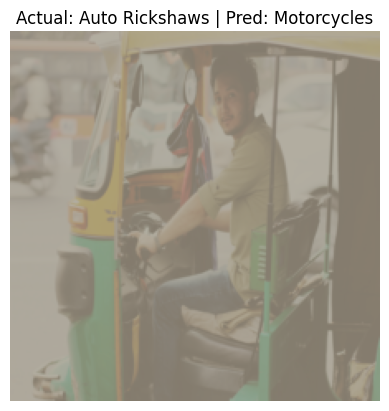

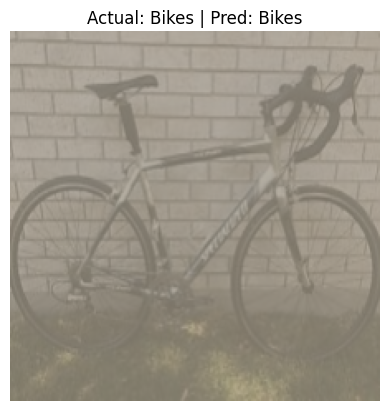

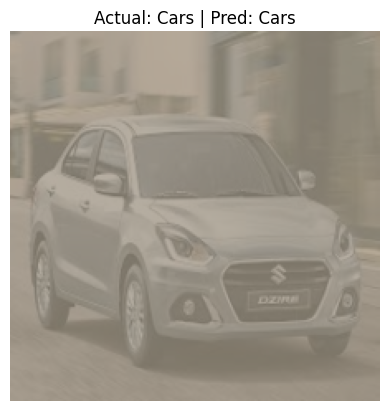

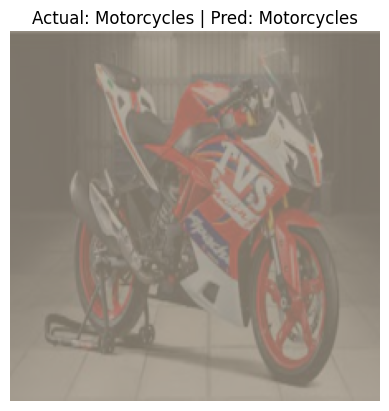

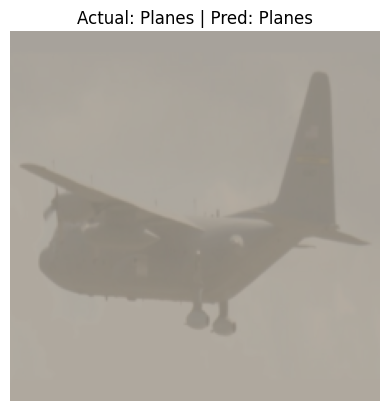

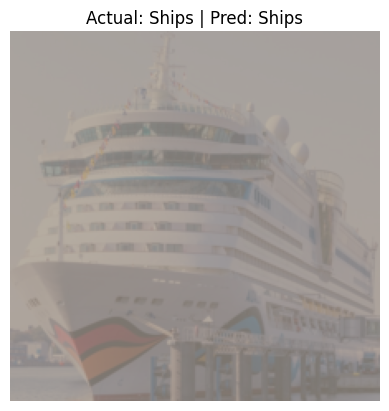

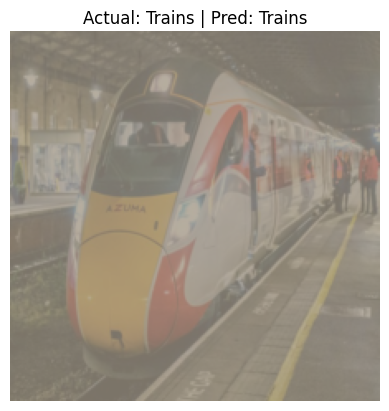

In [33]:
import torch
import torch.nn as nn
from torchvision.models import resnet18, ResNet18_Weights
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loads the model
weights = ResNet18_Weights.DEFAULT
model = resnet18(weights=weights)

# Replace final layer to match 7 vehicle classes
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 7)

# Load the best model weights (assuming best_model.pth is available)
try:
    model.load_state_dict(torch.load("best_model.pth"))
except FileNotFoundError:
    print("Error: best_model.pth not found. Please ensure training was completed successfully.")

    exit()


model = model.to(device)

# Define transforms (should be the same as training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Define data loader for the test set
test_dir = "/content/vehicle-classification/val" # Assuming a test directory exists
test_dataset = datasets.ImageFolder(val_dir, transform=transform)
test_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Get class names
class_names = val_dataset.classes

model.eval()
shown_classes = set()

for inputs, labels in test_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

    for i in range(inputs.size(0)):#so that the model can loop over images in the batch
        label = labels[i].item()
        pred  = preds[i].item()

        # Check if the imshow function is defined, if not, define it here
        if 'imshow' not in globals():
            def imshow(inp, title=None):
                """Display image from tensor."""
                inp = inp.numpy().transpose((1, 2, 0))
                mean = np.array([0.485, 0.456, 0.406])
                std  = np.array([0.229, 0.224, 0.225])
                inp  = std * inp + mean
                inp  = np.clip(inp, 0, 1)
                plt.imshow(inp)
                if title:
                    plt.title(title)
                plt.axis('off')
                plt.show()


        if label not in shown_classes:#this functions ensures the code hhas selected 1 image from the dataset of photos of each class
            imshow(inputs[i].cpu(), title=f"Actual: {class_names[label]} | Pred: {class_names[pred]}")
            shown_classes.add(label)

        if len(shown_classes) == len(class_names):#if photo already chosen , it breaks the function , so it only chooses 1 image
            break
    if len(shown_classes) == len(class_names):
        break